# Churn Rate 2: Bootstrap

We are working in Online Learning platform and working on developing Churn Rate prediction model. We want to know which user have higher probability to leave our platform: starts to visit the website rarely, or he/she does not know about all programs available.

We carefully study what problems our users have. We make interviews with users asking what they like in the platform and what can be added or fixed.

In the Churn Rate part 1 task we completed data aquisition, features engineering and model development

In this task we will do advanced validation of the model and metrics calculations.

# Boostrapped ROC-AUC

When we developed good (as we think) model - for example with ROC-AUC = 93%  
We should also think: How we are sure in our evaluation?  
How we can know that in nex month, when we again calculate metric, ROC-AUC will be 95% and not 76%?  
We really want to know what to expect from the model.  

Obviously model performance will fluctuate, but in what extend?

To answer this question, we need to calculate lower and upper boundaries of the **Confidence Interval**

![](./pic/1.png)

Every metric (and ROC-AUC is not an exclusion) - is a statistics, which depends on dataset on which we calculate it.  
In our task - our dataset is our users, which we include in our test dataset.  
With time our users change their behavior and therefore features are also changing.

## Confidence Intervals  
- 95% Confidence Interval - values diapason of some statistical measure in 95% of cases. Usually, centered interval is considered. Therefore, on the left side and on the right side will be 2.5% of the values which are not included in Confidence Interval.
- Confidence Bounds - bounds of confidence intervals
- LCB (Lower Confidence Bound) - lower boundary of the confidence interval
- UCB (Upper Confidence Bound) - upper boundary of the confidence interval

How we can calculate Confidence Interval for ROC-AUC?

Imagine: you remember only formulas for Normal distribution, but how we can implement them to our task?  
You start Google: "How to calculate Confidence Interval for ROC-AUC". Find some scary looking formulas and do not understand what is happening there :)  
![](./pic/2.png)

Calm down, there is one secret key, how we can start doing this task:

# Empirical distribution function:  
Our general dataset - all users in every moment in future. Ideally, we would simply generate subsets from this general dataset, calculate ROC-AUC on each of them, take Quantiles, which represent LCB and UCB.

Unfortunately, we do not have access to the general dataset.  
We have only one subset of data on which we can build only empirical distribution function.  
We can take subset and generate 10 000 speudo subsets.

# Bootstrap

This method is called "Bootstrap" - it allows us based on our subset imitate generation of other similar subsets. In suits our goal of calculating Confidence Interval for ROC-AUC metrics.

![](./pic/3.png)

we need to create python function for evaluating Confidence Interval for ROC-AUC by bootstrap.  
- inputs:
    - trained classifier (from sklearn library),
    - test subset (X, y), 
    - size of confidence interval and
    - number of boostrap subsets
- result - Confidence Interval for ROC-AUC

In [1]:
import pandas as pd

In [2]:
# function:
from typing import Tuple

import numpy as np
from sklearn.base import ClassifierMixin
from sklearn.metrics import roc_auc_score

def get_percentile_ci(bootstrap_stats, alpha):
    """build percentile confidence interval"""
    left = np.quantile(bootstrap_stats, alpha/2)
    right = np.quantile(bootstrap_stats, 1 - alpha/2)
    return left, right


def roc_auc_ci(
    classifier: ClassifierMixin,
    X: np.ndarray,
    y: np.ndarray,
    conf: float = 0.95,
    n_bootstraps: int = 10_000,
) -> Tuple[float, float]:
    """Returns confidence bounds of the ROC-AUC"""
    # number of records:
    n = len(X)
    # confidence interval size:
    conf = 0.95
    alpha = 1 - conf
    # Point Estimation:
    pe = roc_auc_score(y, classifier.predict_proba(X)[:, 1])
    # generate random subset from initial data n_bootstraps times:
    bootstrap_subsets = []
    for i in range(n_bootstraps):
        random_indices = np.random.choice(n, size=n, replace=False)
        subset = X[random_indices, :]
        bootstrap_subsets.append(subset)
    # calculate roc_auc_score n_bootstraps times
    bootstrap_scores = []
    for X_test_iter in bootstrap_subsets:
        score_iter = roc_auc_score(y, classifier.predict_proba(X_test_iter)[:, 1])
        bootstrap_scores.append(score_iter)
    # calculate percentile confidence interval:
    percentile_ci = get_percentile_ci(bootstrap_scores, pe, alpha)
    lcb = percentile_ci[0]
    ucb = percentile_ci[1]

    return (lcb, ucb)

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X, y = load_breast_cancer(return_X_y=True)

In [4]:
sum(y == 1)

357

In [5]:
len(y)

569

In [6]:
# add
classifier = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
n_bootstraps = 10_000

# number of records:
n = len(X)
# confidence interval size:
conf = 0.95
alpha = 1 - conf
# generate random subset from initial data n_bootstraps times:
bootstrap_scores = []
random_indices_list = list(np.random.choice(np.arange(0, n), (n_bootstraps, n), True))
for random_indices in random_indices_list:
    X_subset = X[random_indices, :]
    y_subset = y[random_indices]
    # calculate roc_auc_score n_bootstraps times
    if len(set(y_subset)) < 2: # otherwise roc_auc is not determined
        pass
    else:
        score_iter = roc_auc_score(y_subset, classifier.predict_proba(X_subset)[:, 1])
        bootstrap_scores.append(score_iter)
# calculate percentile confidence interval:
intervals = []
for i in range(100):
    conf = i / 100
    alpha = 1 - conf
    percentile_ci = get_percentile_ci(bootstrap_scores, alpha)
    lcb = percentile_ci[0]
    ucb = percentile_ci[1]
    diff = ucb - lcb
    intervals.append((conf, diff))

In [7]:
df_plot = pd.DataFrame(intervals, columns=['conf', 'diff'])
df_plot

,conf,diff
0,0.00,0.000000
1,0.01,0.000040
2,0.02,0.000091
3,0.03,0.000144
4,0.04,0.000187
...,...,...
95,0.95,0.007283
96,0.96,0.007624
97,0.97,0.007970
98,0.98,0.008516


<AxesSubplot: xlabel='conf', ylabel='diff'>

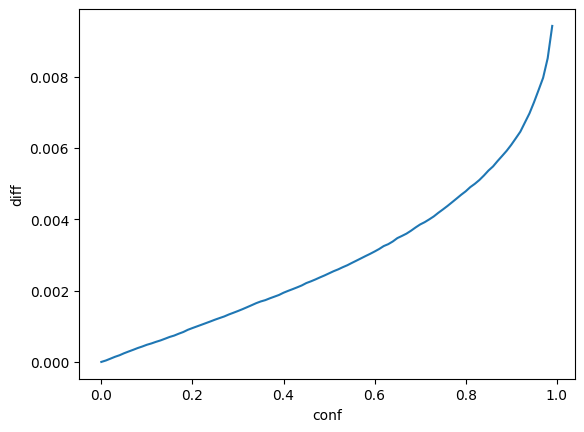

In [8]:
import seaborn as sns
sns.lineplot(data=df_plot, x='conf', y='diff')

In [9]:
# imbalanced dataset:
df_credit = pd.read_csv('./data/creditcard.csv')
df_credit

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [10]:
X = df_credit.drop(columns=['Class'])
X = np.array(X)
X

array([[ 0.00000000e+00, -1.35980713e+00, -7.27811733e-02, ...,
         1.33558377e-01, -2.10530535e-02,  1.49620000e+02],
       [ 0.00000000e+00,  1.19185711e+00,  2.66150712e-01, ...,
        -8.98309914e-03,  1.47241692e-02,  2.69000000e+00],
       [ 1.00000000e+00, -1.35835406e+00, -1.34016307e+00, ...,
        -5.53527940e-02, -5.97518406e-02,  3.78660000e+02],
       ...,
       [ 1.72788000e+05,  1.91956501e+00, -3.01253846e-01, ...,
         4.45477214e-03, -2.65608286e-02,  6.78800000e+01],
       [ 1.72788000e+05, -2.40440050e-01,  5.30482513e-01, ...,
         1.08820735e-01,  1.04532821e-01,  1.00000000e+01],
       [ 1.72792000e+05, -5.33412522e-01, -1.89733337e-01, ...,
        -2.41530880e-03,  1.36489143e-02,  2.17000000e+02]])

In [11]:
y = df_credit['Class'].values
len(y)

284807

In [12]:
sum(y == 1)

492

In [28]:
list(np.random.choice(np.arange(0, 10), (5, 10), True))

[array([7, 0, 1, 7, 1, 0, 3, 2, 3, 7]),
 array([8, 0, 6, 1, 5, 0, 8, 1, 5, 4]),
 array([9, 7, 4, 1, 9, 4, 4, 7, 9, 1]),
 array([7, 0, 9, 6, 2, 7, 3, 8, 7, 6]),
 array([7, 2, 4, 6, 1, 1, 9, 3, 0, 4])]

In [34]:
len(set(y[test_indeces])) < 2

True

counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter: 56
counter: 57
counter: 58
counter: 59
counter: 60
counter: 61
counter: 62
counter: 63
counter: 64
counter: 65
counter: 66
counter: 67
counter: 68
counter: 69
counter: 70
counter: 71
counter: 72
counter: 73
counter: 74
counter: 75
counter: 76
counter: 77
counter: 78
counter: 79
counter: 80
counter: 81
counter: 82
counter: 83
co

<AxesSubplot: xlabel='conf', ylabel='diff'>

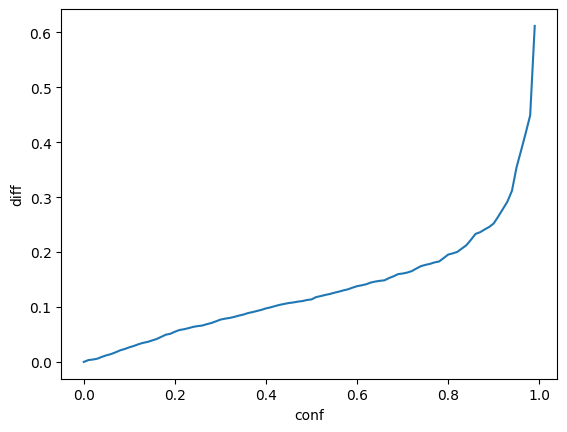

In [45]:
# add
classifier = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
n_bootstraps = 1000

# number of records:
n = len(X)
# confidence interval size:
conf = 0.95
alpha = 1 - conf
# generate random subset from initial data n_bootstraps times:
bootstrap_scores = []
random_indices_list = list(np.random.choice(np.arange(0, n), (n_bootstraps, n//100), True))
counter = 0
single_class_subsets = []
for random_indices in random_indices_list:
    print(f'counter: {counter}')
    counter += 1
    X_subset = X[random_indices, :]
    y_subset = y[random_indices]
    # calculate roc_auc_score n_bootstraps times
    if len(set(y_subset)) < 2: # otherwise roc_auc is not determined
        pass
        print('one class subset')
        single_class_subsets.append(y_subset)
    else:
        score_iter = roc_auc_score(y_subset, classifier.predict_proba(X_subset)[:, 1])
        bootstrap_scores.append(score_iter)
# calculate percentile confidence interval:
intervals = []
for i in range(100):
    conf = i / 100
    alpha = 1 - conf
    percentile_ci = get_percentile_ci(bootstrap_scores, alpha)
    lcb = percentile_ci[0]
    ucb = percentile_ci[1]
    diff = ucb - lcb
    intervals.append((conf, diff))
df_plot = pd.DataFrame(intervals, columns=['conf', 'diff'])
sns.lineplot(data=df_plot, x='conf', y='diff')

In [46]:
np.sum(y_subset)

4

In [47]:
single_class_subsets

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [14]:
# add
classifier = LogisticRegression(solver="liblinear", random_state=0).fit(X, y)
n_bootstraps = 1000

# number of records:
n = len(X)
# confidence interval size:
conf = 0.95
alpha = 1 - conf
# generate random subset from initial data n_bootstraps times:
bootstrap_scores = []
random_indices_list = list(np.random.choice(np.arange(0, n), (n_bootstraps, n), True))
counter = 0
single_class_subsets = []
for random_indices in random_indices_list:
    print(f'counter: {counter}')
    counter += 1
    X_subset = X[random_indices, :]
    y_subset = y[random_indices]
    # calculate roc_auc_score n_bootstraps times
    if len(set(y_subset)) < 2: # otherwise roc_auc is not determined
        pass
        print('one class subset')
        single_class_subsets.append(y_subset)
    else:
        score_iter = roc_auc_score(y_subset, classifier.predict_proba(X_subset)[:, 1])
        bootstrap_scores.append(score_iter)
# calculate percentile confidence interval:
percentile_ci = get_percentile_ci(bootstrap_scores, alpha)
lcb = percentile_ci[0]
ucb = percentile_ci[1]

counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9


In [15]:
bootstrap_scores

[0.9178175407896265,
 0.9265744335572955,
 0.920346993599585,
 0.9207796388399047,
 0.9215705599597249,
 0.9153380111054261,
 0.913192982369982,
 0.9279135070094622,
 0.9144986556802517,
 0.9242158305094844]

In [16]:
y_subset

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

1. Imbalanced Classes: When the classes are heavily imbalanced, it's possible for a bootstrap sample to contain only one class. As you correctly pointed out, the ROC-AUC score can't be calculated in this case. Your function appears to ignore these subsets by skipping the ROC-AUC calculation when len(set(y_subset)) < 2. While this will prevent errors, it might bias your results. One potential solution could be to ensure that each bootstrap sample contains at least one instance of each class. However, this may introduce its own biases since it's not a truly random sample. Alternatively, you could use stratified bootstrapping which maintains the class distribution in the bootstrapped sample.

2. Confidence Level: You accept a conf parameter in your function but then immediately override it with conf = 0.95. You should remove this line to respect the passed conf parameter.

3. Repeated calculation of alpha: alpha is calculated within roc_auc_ci and also within get_percentile_ci. You could calculate it once and pass it to the function to avoid duplicate calculations.

4. The classifier is fit to the entire data before bootstrapping: A more accurate approach is to fit the classifier within the bootstrap loop, using only the bootstrapped data. This simulates the variability that comes from the fitting process itself.

5. Use of print for debugging: Consider using Python's logging module for a more flexible approach to logging.

In [ ]:
from typing import Tuple

import numpy as np
from sklearn.base import ClassifierMixin
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def get_percentile_ci(bootstrap_stats, alpha):
    """build percentile confidence interval"""
    left = np.quantile(bootstrap_stats, alpha/2)
    right = np.quantile(bootstrap_stats, 1 - alpha/2)
    return left, right

def roc_auc_ci(
    classifier: ClassifierMixin,
    X: np.ndarray,
    y: np.ndarray,
    conf: float = 0.95,
    n_bootstraps: int = 10_000,
) -> Tuple[float, float]:
    """Returns confidence bounds of the ROC-AUC"""
    alpha = 1 - conf
    bootstrap_scores = []
    for _ in range(n_bootstraps):
        X_sample, y_sample = resample(X, y, stratify=y)
        score = roc_auc_score(y_sample, classifier.predict_proba(X_sample)[:, 1])
        bootstrap_scores.append(score)

    return get_percentile_ci(bootstrap_scores, alpha)
